In [10]:
import os 
import numpy as np
import random
import math
import json
from functools import partial
import urllib.request
from typing import Optional, Tuple
from urllib.error import HTTPError

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.nn.functional import softmax
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms
import pytorch_lightning as pl
from torch.nn.init import xavier_uniform_
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [2]:
plt.set_cmap('cividis')
%matplotlib inline
set_matplotlib_formats('svg', 'pdf') # For export
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.reset_orig()

/tmp/ipykernel_527/1970155340.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [3]:
DATASET_PATH = "data"  # path to datasets (e.g. CIFAR10)
CHECKPOINT_PATH = "saved_models/tutorial6"  # path to pretrained models

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [4]:
seed_number = 0

torch.manual_seed(seed_number)
# https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch.use_deterministic_algorithms
# cumsum_cuda_kernel does not have deterministic implementation
# (yet)
torch.use_deterministic_algorithms(True, warn_only=True)

In [5]:
# Set device:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda:0


In [6]:
def scaled_dot_product_attn(
    q: torch.Tensor,
    k: torch.Tensor,
    v: torch.Tensor,
    mask: Optional[torch.Tensor] = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Implement scaled dot-product attention for batched queries, keys and values.
    
    Args: 
        q: Queries in shape `(N, seq_length, d_k)` or `(seq_length, d_k)`
        k: Keys in shape `(N, seq_length', d_k)` or `(seq_length', d_k)` 
            (in practice, `seq_length' == seq_length`)
        v: Values in shape `(N, seq_length', d_v)` or `(seq_length', d_v)`
        mask: Optional mask for padding.     
    
    Returns: 
        Weighted values $softmax(qk^T / sqrt(d_k)) v$
        in shape `(N, seq_length, d_v)` or `(seq_length, d_v,)` and attention 
        weights $softmax(qk^T / sqrt(d_k))$ in shape `(N, seq_length, seq_length')`
        or `(seq_length, seq_length')`
    """

    # shape checks
    assert q.shape[-1] == k.shape[-1]
    assert k.shape[-2] == v.shape[-2]

    # calculate attention logits
    attn_logits = q @ k.mT / math.sqrt(q.shape[-1])

    # apply mask if provided
    if mask is not None:
        attn_logits.masked_fill_(
            mask==0,
            -1e6
        )
    
    # calculate attention weights
    attn_weights = softmax(attn_logits, dim=-1)

    return attn_weights @ v, attn_weights

In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim: int, embed_dim: int, num_heads: int, use_bias: bool = False) -> None:
        """
        Multi-head attention.

        Args:
            input_dim: In the attention paper [1], `d_k = d_v`, which is here 
                referred to as the input dimensionality
            embed_dim: Referred to as `d_model` in [1]
            num_heads: Number of heads, `h` in [1]
            use_bias: Whether a bias term is used. Default is `False`

        [1] http://arxiv.org/abs/1706.03762
        """
        super().__init__()
        assert embed_dim % num_heads == 0, (
            "In the original attention paper, `d_model = hd_v = hd_k`"
            f"was chosen, hence `d_model`:`num_heads` cannot be {embed_dim}:{num_heads}"
        )

        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.use_bias = use_bias

        # dim of queries, keys and values per self-attention head:
        self.head_dim = int(embed_dim / num_heads) 

        # stack all weight matrices per self-attention head
        self.qkv_proj = nn.Linear(
            in_features=input_dim, 
            out_features=3 * embed_dim,
            bias=use_bias,
        )
        self.o_proj = nn.Linear(
            in_features=embed_dim,
            out_features=embed_dim,
            bias=use_bias,   
        )  # `W^O`
        
        self._reset_parameters()

    def _reset_parameters(self) -> None:
        """
        Initialize (reset) params.
        """

        # weights:
        xavier_uniform_(self.qkv_proj.weight)
        xavier_uniform_(self.o_proj.weight)

        if self.use_bias:
            # biases:
            self.qkv_proj.bias.data.fill_(0)
            self.o_proj.bias.data.fill_(0)

In [ ]:
# TODO: implement `expand_mask` function & `forward` function inside `MultiHeadAttention` class

## Miscellaneous & Tests

In [8]:
import cpuinfo

# Getting detailed CPU information
info = cpuinfo.get_cpu_info()

# Print the entire information dictionary
# print(info)

# If you want to print specific details like the brand, you can do so as follows:
print("CPU Brand:", info['brand_raw'])


CPU Brand: Intel(R) Core(TM) i9-10920X CPU @ 3.50GHz


In [9]:
k = torch.rand(3, 2)
print(f"Random tensor:\n\n{k}\n\n{k.mT}, {k.mT.shape}")

Random tensor:

tensor([[0.4963, 0.7682],
        [0.0885, 0.1320],
        [0.3074, 0.6341]])

tensor([[0.4963, 0.0885, 0.3074],
        [0.7682, 0.1320, 0.6341]]), torch.Size([2, 3])


In [10]:
mask = torch.tensor([[0, 2, 3, 4], [0, 1, 2, -3]], dtype=torch.bool)
attn_logits = torch.rand(*mask.shape)
print(f"Mask:\n{mask}\n\nAttention logits:\n{attn_logits}")

Mask:
tensor([[False,  True,  True,  True],
        [False,  True,  True,  True]])

Attention logits:
tensor([[0.4901, 0.8964, 0.4556, 0.6323],
        [0.3489, 0.4017, 0.0223, 0.1689]])


In [11]:
attn_logits.masked_fill_(
    mask==0,
    value=-10
)

tensor([[-10.0000,   0.8964,   0.4556,   0.6323],
        [-10.0000,   0.4017,   0.0223,   0.1689]])

In [12]:
seq_length = 4
d_k = 2
d_v = 3

q = torch.randn(seq_length, d_k)
k = torch.randn(seq_length, d_k)
v = torch.randn(seq_length, d_v)

attention, values = scaled_dot_product_attn(
    q=q,
    k=k,
    v=v,
)
print(f"Attention weights:\n\n{attention}\n\nValues:\n\n{values}")

Attention weights:

tensor([[-0.4961, -0.0490, -0.9716],
        [-0.4659, -0.0843, -0.9952],
        [-0.4182, -0.0311, -0.9517],
        [-0.3358,  0.6520, -0.3380]])

Values:

tensor([[0.3778, 0.3911, 0.0938, 0.1373],
        [0.2806, 0.4816, 0.1043, 0.1335],
        [0.1887, 0.5252, 0.1405, 0.1455],
        [0.3111, 0.0778, 0.2936, 0.3175]])


In [13]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
print(f"Q\n\n{q}\n")
print(f"K\n\n{k}\n")
print(f"V\n\n{v}\n")

Q

tensor([[ 1.1317, -0.6455],
        [-1.7703,  0.2143],
        [-0.5382,  0.5880]])

K

tensor([[ 1.6059,  0.4279],
        [-0.6776,  1.0422],
        [-1.9513,  0.4186]])

V

tensor([[ 3.3214,  0.8764],
        [ 1.2345, -1.1642],
        [-0.0240,  0.6480]])



In [14]:
attention, values = scaled_dot_product_attn(q, k, v)
print(f"Values\n\n{values}\n")
print(f"Attention\n\n{attention}\n")

Values

tensor([[0.8476, 0.1030, 0.0494],
        [0.0094, 0.1807, 0.8098],
        [0.1260, 0.3879, 0.4860]])

Attention

tensor([[ 2.9412,  0.6550],
        [ 0.2350,  0.3226],
        [ 0.8858, -0.0263]])



In [15]:
softmax(torch.tensor([0.1037, -0.1441, -0.1073]))

/tmp/ipykernel_177/739439436.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.tensor([0.1037, -0.1441, -0.1073]))


tensor([0.3861, 0.3013, 0.3126])

In [16]:
seq_len, d_k = 3, 2
q = torch.tensor([[[-0.1335, 0.3415], [-0.0716, -0.0909], [-1.3297, -0.5426]]])
k = torch.tensor([[[0.5471, 0.6431], [-0.7905, -0.9058], [-0.2607, -0.5465]]])
v = torch.tensor([[[2.1174, -1.7118], [0.1651, 1.5819], [0.4485, 0.0330]]])
values, attention = scaled_dot_product_attn(q, k, v)
print(f"Q\n\n{q}\n")
print(f"K\n\n{k}\n")
print(f"V\n\n{v}\n")
print(f"Values\n\n{values}\n")
print(f"Attention\n\n{attention}\n")

Q

tensor([[[-0.1335,  0.3415],
         [-0.0716, -0.0909],
         [-1.3297, -0.5426]]])

K

tensor([[[ 0.5471,  0.6431],
         [-0.7905, -0.9058],
         [-0.2607, -0.5465]]])

V

tensor([[[ 2.1174, -1.7118],
         [ 0.1651,  1.5819],
         [ 0.4485,  0.0330]]])

Values

tensor([[[ 1.0074, -0.1738],
         [ 0.8519,  0.0590],
         [ 0.4358,  0.7891]]])

Attention

tensor([[[0.3861, 0.3013, 0.3126],
         [0.3024, 0.3575, 0.3401],
         [0.0931, 0.5930, 0.3139]]])



In [17]:
out = q @ k.mT / math.sqrt(d_k)
softmax(out, dim=-1)

tensor([[[0.3861, 0.3013, 0.3126],
         [0.3024, 0.3575, 0.3401],
         [0.0931, 0.5930, 0.3139]]])

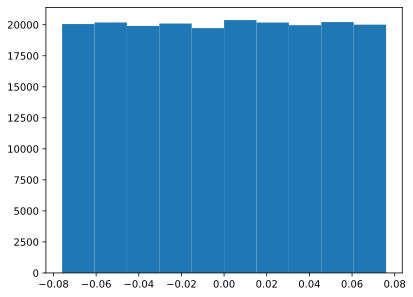

In [8]:
model = nn.Linear(
    in_features=256,
    out_features=784,
)
torch.nn.init.xavier_uniform_(model.weight, gain=1.0)
plt.hist(
    model.weight.flatten().detach().numpy()
)
plt.show()
plt.close()

In [24]:
model.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [17]:
model.bias.shape, model.bias.dtype

(torch.Size([784]), torch.float32)

In [9]:
torch.max(
    torch.abs(
        model.weight
    )
)

tensor(0.0760, grad_fn=<MaxBackward1>)

### TODO's:

The function `scaled_dot_product_attn` ignores the batch dimension, expand function.